[*********************100%***********************]  1 of 1 completed


### 💡 HUMAN-READABLE INSIGHTS

- TSLA closed higher than previous day: **346.97 📈**

- Market sentiment: **Neutral 😐**

**Last Close Price for TSLA: 346.97**

**Gradient Boosting CV MSE:** 0.003112, R2: -1.2530

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


**Gradient Boosting Next-Day Return Prediction:** -0.00737 (📉 Downtrend expected)

**LSTM Next-Day Return Prediction:** -0.00290 (📉 Downtrend expected)

---

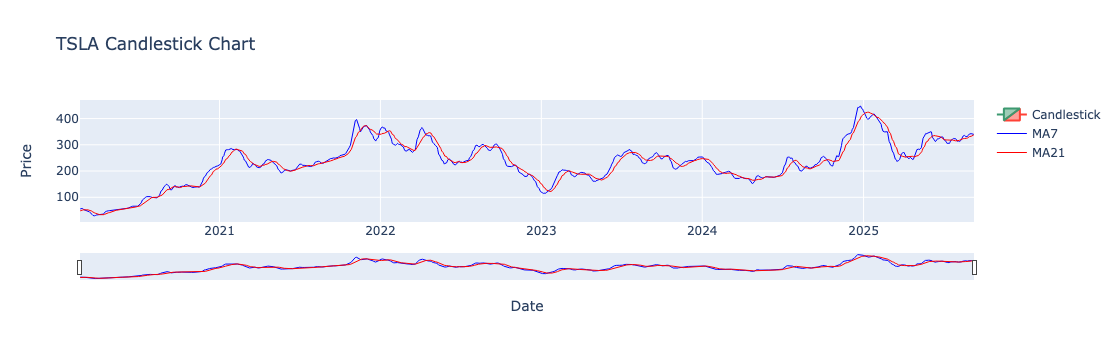

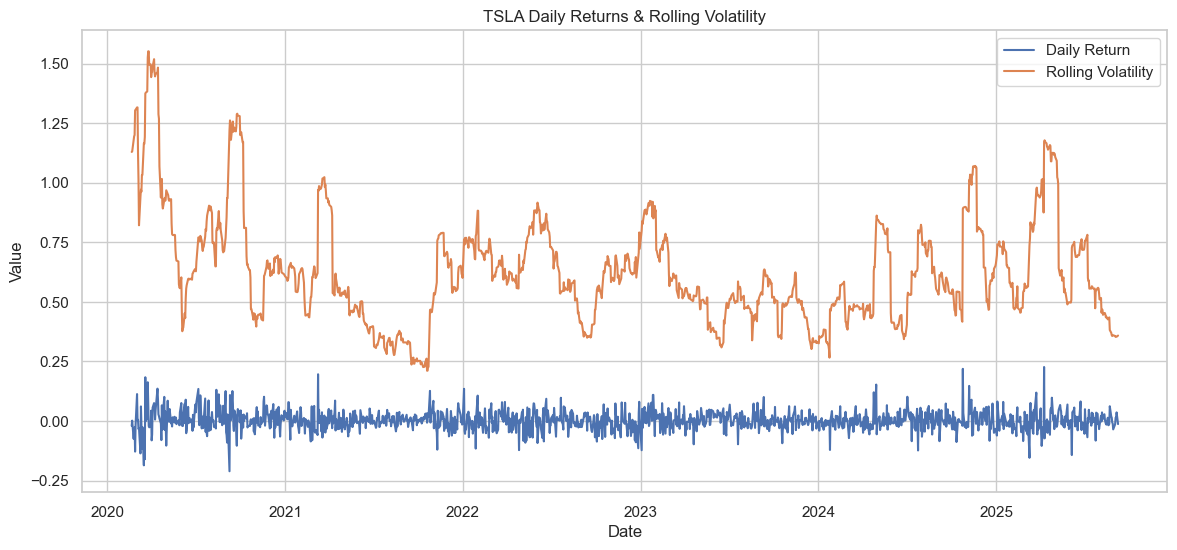

**Enhanced dataset saved as TSLA_Enhanced.csv**

In [37]:
# ==============================================
# Robust Stock Market Analysis Tool 
# ==============================================

# -------------------------------
# 0. Suppress Warnings for Clean Output
# -------------------------------
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs

import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning

# -------------------------------
# 1. Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
from textblob import TextBlob
import requests
from bs4 import BeautifulSoup
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from IPython.display import display, Markdown

sns.set(style="whitegrid")

# -------------------------------
# 2. User Input: Stock & Dates
# -------------------------------
STOCK = 'TSLA'  # Change to TSLA, NVDA, or any valid stock ticker
START_DATE = '2020-01-01'
END_DATE = datetime.datetime.today().strftime('%Y-%m-%d')

# -------------------------------
# 3. Fetch Historical Data with Validation
# -------------------------------
try:
    df = yf.download(STOCK, start=START_DATE, end=END_DATE, auto_adjust=True)
    if df.empty:
        raise ValueError(f"No data found for stock symbol '{STOCK}'. Please check the ticker.")
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
except Exception as e:
    raise ValueError(f"Error fetching data for '{STOCK}': {e}")

# -------------------------------
# 4. Feature Engineering
# -------------------------------
df['Daily_Return'] = df['Close'].pct_change()
df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod()
df['Rolling_Volatility'] = df['Daily_Return'].rolling(21).std() * np.sqrt(252)

# Moving Averages
df['MA7'] = df['Close'].rolling(7).mean()
df['MA21'] = df['Close'].rolling(21).mean()

# RSI & MACD
df['RSI'] = RSIIndicator(close=df['Close'].squeeze(), window=14).rsi()
macd = MACD(close=df['Close'].squeeze())
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# -------------------------------
# 5. Sentiment Analysis
# -------------------------------
def fetch_news_sentiment(stock_symbol, num_articles=5):
    try:
        url = f'https://finance.yahoo.com/quote/{stock_symbol}?p={stock_symbol}&.tsrc=fin-srch'
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        headlines = soup.find_all('h3', class_='Mb(5px)')
        headlines = [h.get_text() for h in headlines[:num_articles]]
        sentiments = [TextBlob(h).sentiment.polarity for h in headlines]
        return np.mean(sentiments) if sentiments else 0
    except:
        return 0

df['Sentiment'] = fetch_news_sentiment(STOCK)

# -------------------------------
# 6. Human-Readable Insights
# -------------------------------
close = df['Close'].squeeze().dropna()
ma7 = df['MA7'].squeeze().dropna()
ma21 = df['MA21'].squeeze().dropna()
vol = df['Rolling_Volatility'].squeeze().dropna()

insights = []

if len(close) < 2:
    insights.append("- Not enough data to generate insights.")
else:
    if close.iloc[-1] > close.iloc[-2]:
        insights.append(f"- {STOCK} closed higher than previous day: **{close.iloc[-1]:.2f} 📈**")
    else:
        insights.append(f"- {STOCK} closed lower than previous day: **{close.iloc[-1]:.2f} 📉**")

    if ma7.iloc[-1] > ma21.iloc[-1] and ma7.iloc[-2] <= ma21.iloc[-2]:
        insights.append("- Short-term MA crossed above long-term MA: **Bullish signal ✅**")
    elif ma7.iloc[-1] < ma21.iloc[-1] and ma7.iloc[-2] >= ma21.iloc[-2]:
        insights.append("- Short-term MA crossed below long-term MA: **Bearish signal ❌**")

    if vol.iloc[-1] > vol.mean():
        insights.append("- Stock volatility is above average: **High risk ⚠️**")

    sentiment_val = df['Sentiment'].iloc[-1]
    if sentiment_val > 0.05:
        insights.append("- Market sentiment: **Positive 😊**")
    elif sentiment_val < -0.05:
        insights.append("- Market sentiment: **Negative 😟**")
    else:
        insights.append("- Market sentiment: **Neutral 😐**")

display(Markdown("### 💡 HUMAN-READABLE INSIGHTS"))
for i in insights:
    display(Markdown(i))

# -------------------------------
# 7. Last Close Price
# -------------------------------
display(Markdown(f"**Last Close Price for {STOCK}: {close.iloc[-1]:.2f}**"))

# -------------------------------
# 8. Prepare Target for Prediction
# -------------------------------
df['Target'] = df['Daily_Return'].shift(-1)
df.dropna(inplace=True)
feature_cols = ['Close', 'MA7', 'MA21', 'RSI', 'MACD', 'MACD_Signal', 'Sentiment', 'Rolling_Volatility']
X = df[feature_cols]
y = df['Target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------
# 9. Gradient Boosting Prediction
# -------------------------------
tscv = TimeSeriesSplit(n_splits=5)
mse_list, r2_list = [], []

for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    mse_list.append(mean_squared_error(y_test, y_pred))
    r2_list.append(r2_score(y_test, y_pred))

display(Markdown(f"**Gradient Boosting CV MSE:** {np.mean(mse_list):.6f}, R2: {np.mean(r2_list):.4f}"))

# Next-Day Prediction
X_last = X_scaled[-1].reshape(1, -1)
next_day_return_gbr = gbr.predict(X_last)[0]

# -------------------------------
# 10. LSTM Prediction
# -------------------------------
look_back = 10
X_lstm, y_lstm = [], []
for i in range(look_back, len(X_scaled)):
    X_lstm.append(X_scaled[i-look_back:i])
    y_lstm.append(y.iloc[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_lstm, y_lstm, epochs=20, batch_size=32, verbose=0)

X_last_lstm = X_scaled[-look_back:].reshape(1, look_back, X_scaled.shape[1])
next_day_return_lstm = model.predict(X_last_lstm)[0][0]

# Display Predictions
def interpret_return_emoji(ret):
    if ret > 0: return "📈 Uptrend expected"
    elif ret < 0: return "📉 Downtrend expected"
    else: return "➖ Stable"

display(Markdown(f"**Gradient Boosting Next-Day Return Prediction:** {next_day_return_gbr:.5f} ({interpret_return_emoji(next_day_return_gbr)})"))
display(Markdown(f"**LSTM Next-Day Return Prediction:** {next_day_return_lstm:.5f} ({interpret_return_emoji(next_day_return_lstm)})"))
display(Markdown("---"))

# -------------------------------
# 11. Visualization
# -------------------------------
fig = go.Figure(data=[go.Candlestick(
    x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick'
)])
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA7'], line=dict(color='blue', width=1), name='MA7'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA21'], line=dict(color='red', width=1), name='MA21'))
fig.update_layout(title=f"{STOCK} Candlestick Chart", xaxis_title="Date", yaxis_title="Price")
fig.show()

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Daily_Return'], label='Daily Return')
plt.plot(df['Date'], df['Rolling_Volatility'], label='Rolling Volatility')
plt.title(f"{STOCK} Daily Returns & Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# -------------------------------
# 12. Save Enhanced Dataset
# -------------------------------
df.to_csv(f"{STOCK}_Enhanced.csv", index=False)
display(Markdown(f"**Enhanced dataset saved as {STOCK}_Enhanced.csv**"))
